# Control the corrected skin temperature for ERA5

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


In [3]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=1)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


>> Function definition START

In [4]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [5]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

>> Function definition END

# CREG025.L75  Grid

In [6]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

# CREG025.L75  Bathymetry

In [7]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)

# Read the corrected ERA skin temperature

In [8]:
lyear=2000

In [25]:
PATHIN='/home1/datawork/ctalandi/PRE-POST/FREDY/WEIGHTS/CREG025.L75/OFF-LINE/'
ds_skt=xr.open_dataset(PATHIN+'CREG025.L75_drowned_skt_ERA5_y'+str(lyear)+'.nc')
ds_skt=ds_skt.chunk({'time_counter':512})
ds_skt

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) timedelta64[ns] NaT NaT NaT NaT ... NaT NaT NaT
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    skt           (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [26]:
# Rebuild the time axis 
new_time=pd.date_range(start=str(lyear)+'-01-01',end=str(lyear+1)+'-01-01',freq='H',inclusive='left')
new_time
ds_skt=ds_skt.assign_coords({'time_counter':new_time})
ds_skt

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-01 ... 2000-12-31T23:...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    skt           (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [27]:
ds_skt['skt']=xr.where(tmask2D == 0.,np.nan, ds_skt['skt'])

In [28]:
if False:
    plt.figure(figsize=(20,15)) 
    ds_skt['skt'].isel(time_counter=20).plot(vmin=-50.,vmax=50.,cmap='Spectral_r')

# Read the original ERA t2m air temperature

In [29]:
PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
ds_t2m=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(lyear)+'.nc')#,chunks='auto')
ds_t2m=ds_t2m.chunk({'time_counter':512})
ds_t2m

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) timedelta64[ns] 36524 days 00:00:00 ... 3688...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    t2            (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [30]:
# Rebuild the time axis 
new_time=pd.date_range(start=str(lyear)+'-01-01',periods=8784,freq='H',inclusive='left')
new_time
ds_t2m=ds_t2m.assign_coords({'time_counter':new_time})
ds_t2m

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-01 ... 2000-12-31T23:...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    t2            (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [31]:
# Convert into DegC
ds_t2m['t2']=xr.where(tmask2D == 0.,np.nan, ds_t2m['t2']-273.)

In [33]:
# Add the full correction
ds_t2m['t2cor']=(ds_t2m['t2']+ds_skt['skt']).compute()

# Identify grid points where the time-series will be plot 

In [17]:
bx_SVAL={'name':'SVA','lon_min':320,'lon_max':320,'lat_min':350,'lat_max':350}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500}
bx_BGYR={'name':'BGY','lon_min':180,'lon_max':180,'lat_min':500,'lat_max':500}
bx_BARE={'name':'BAR','lon_min':400,'lon_max':400,'lat_min':350,'lat_max':350}
bx_EURA={'name':'EUR','lon_min':320,'lon_max':320,'lat_min':420,'lat_max':420}

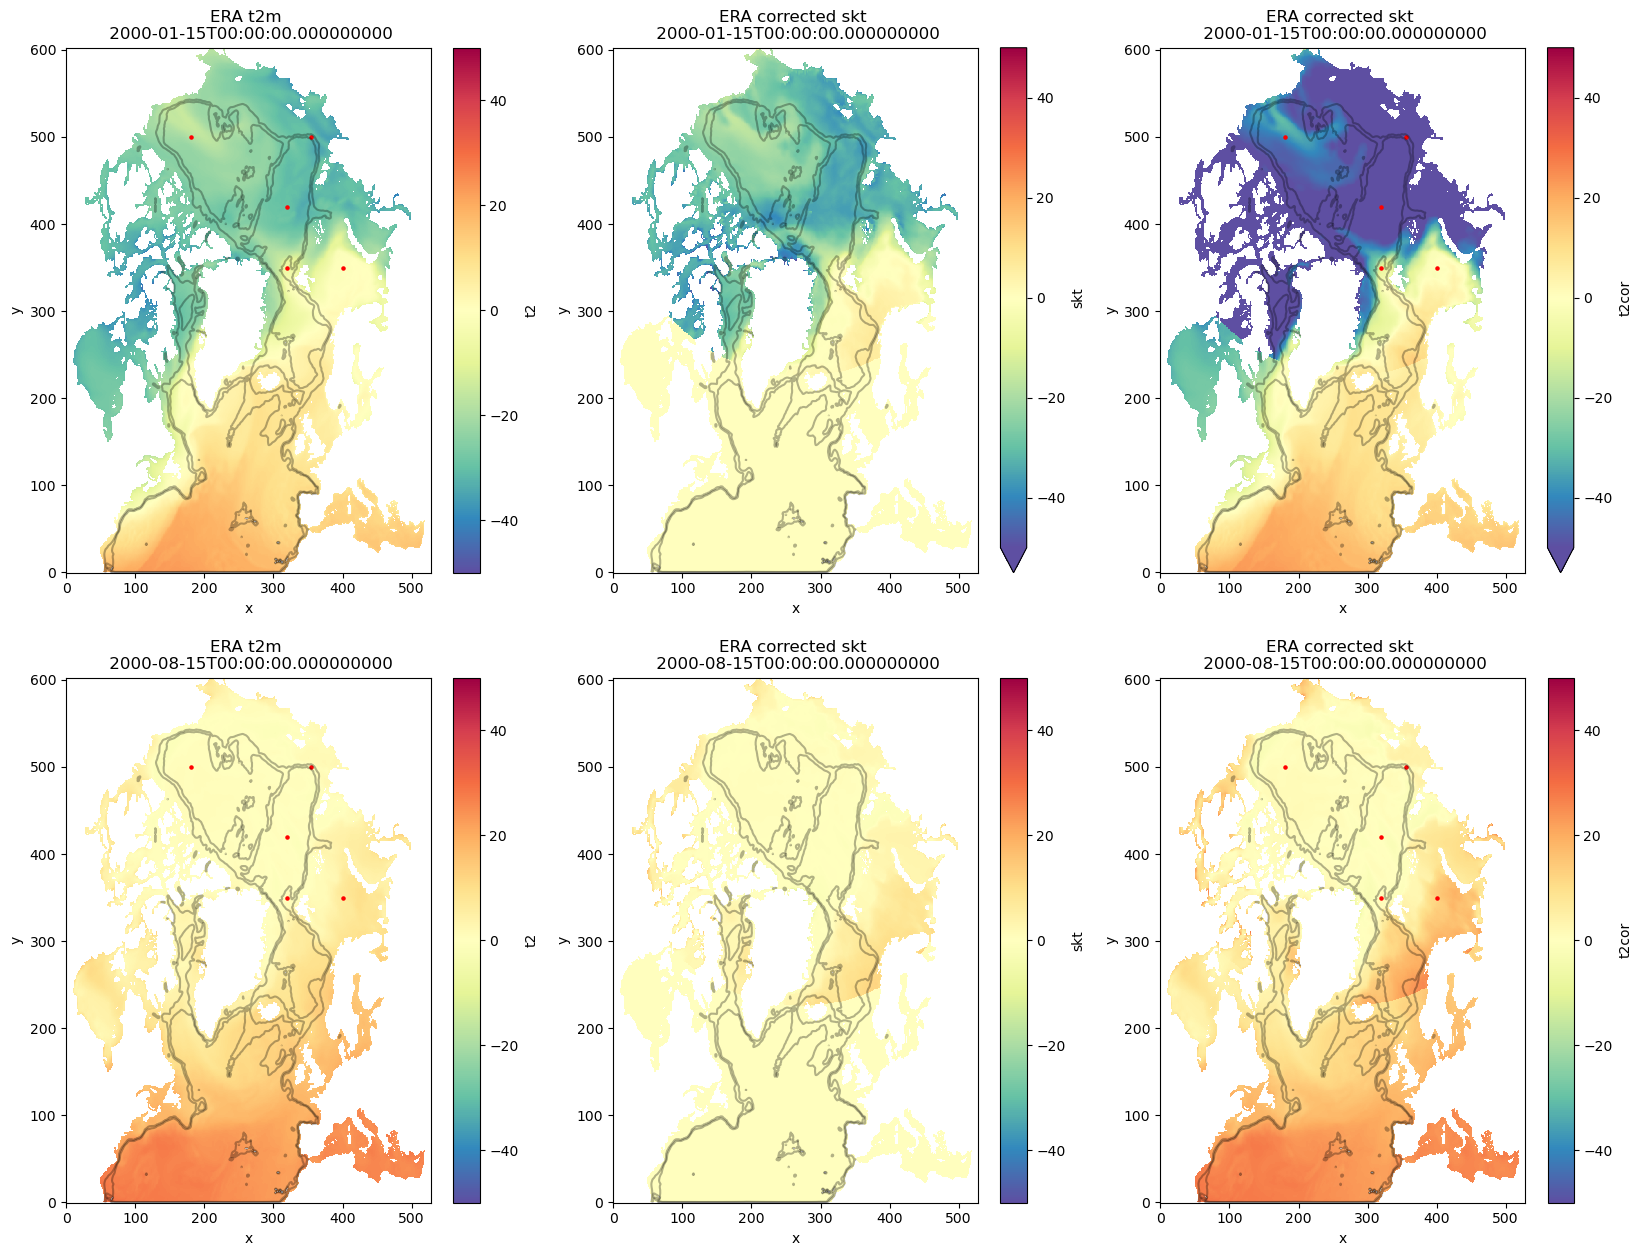

In [41]:
plt.figure(figsize=(20,15))

iter='2000-01-15 00:00:00' # For winter 
plt.subplot(231)
ds_t2m['t2'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
plt.title('ERA t2m \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(232)
ds_skt['skt'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA corrected skt \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(233)
ds_t2m['t2cor'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
plt.title('ERA corrected skt \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

iter='2000-08-15 00:00:00' # For Summer 
plt.subplot(234)
ds_t2m['t2'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
plt.title('ERA t2m \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(235)
ds_skt['skt'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA corrected skt \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(236)
ds_t2m['t2cor'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
plt.title('ERA corrected skt \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))


if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2m_skt_corrected_y'+str(lyear)+'.png',dpi=300)


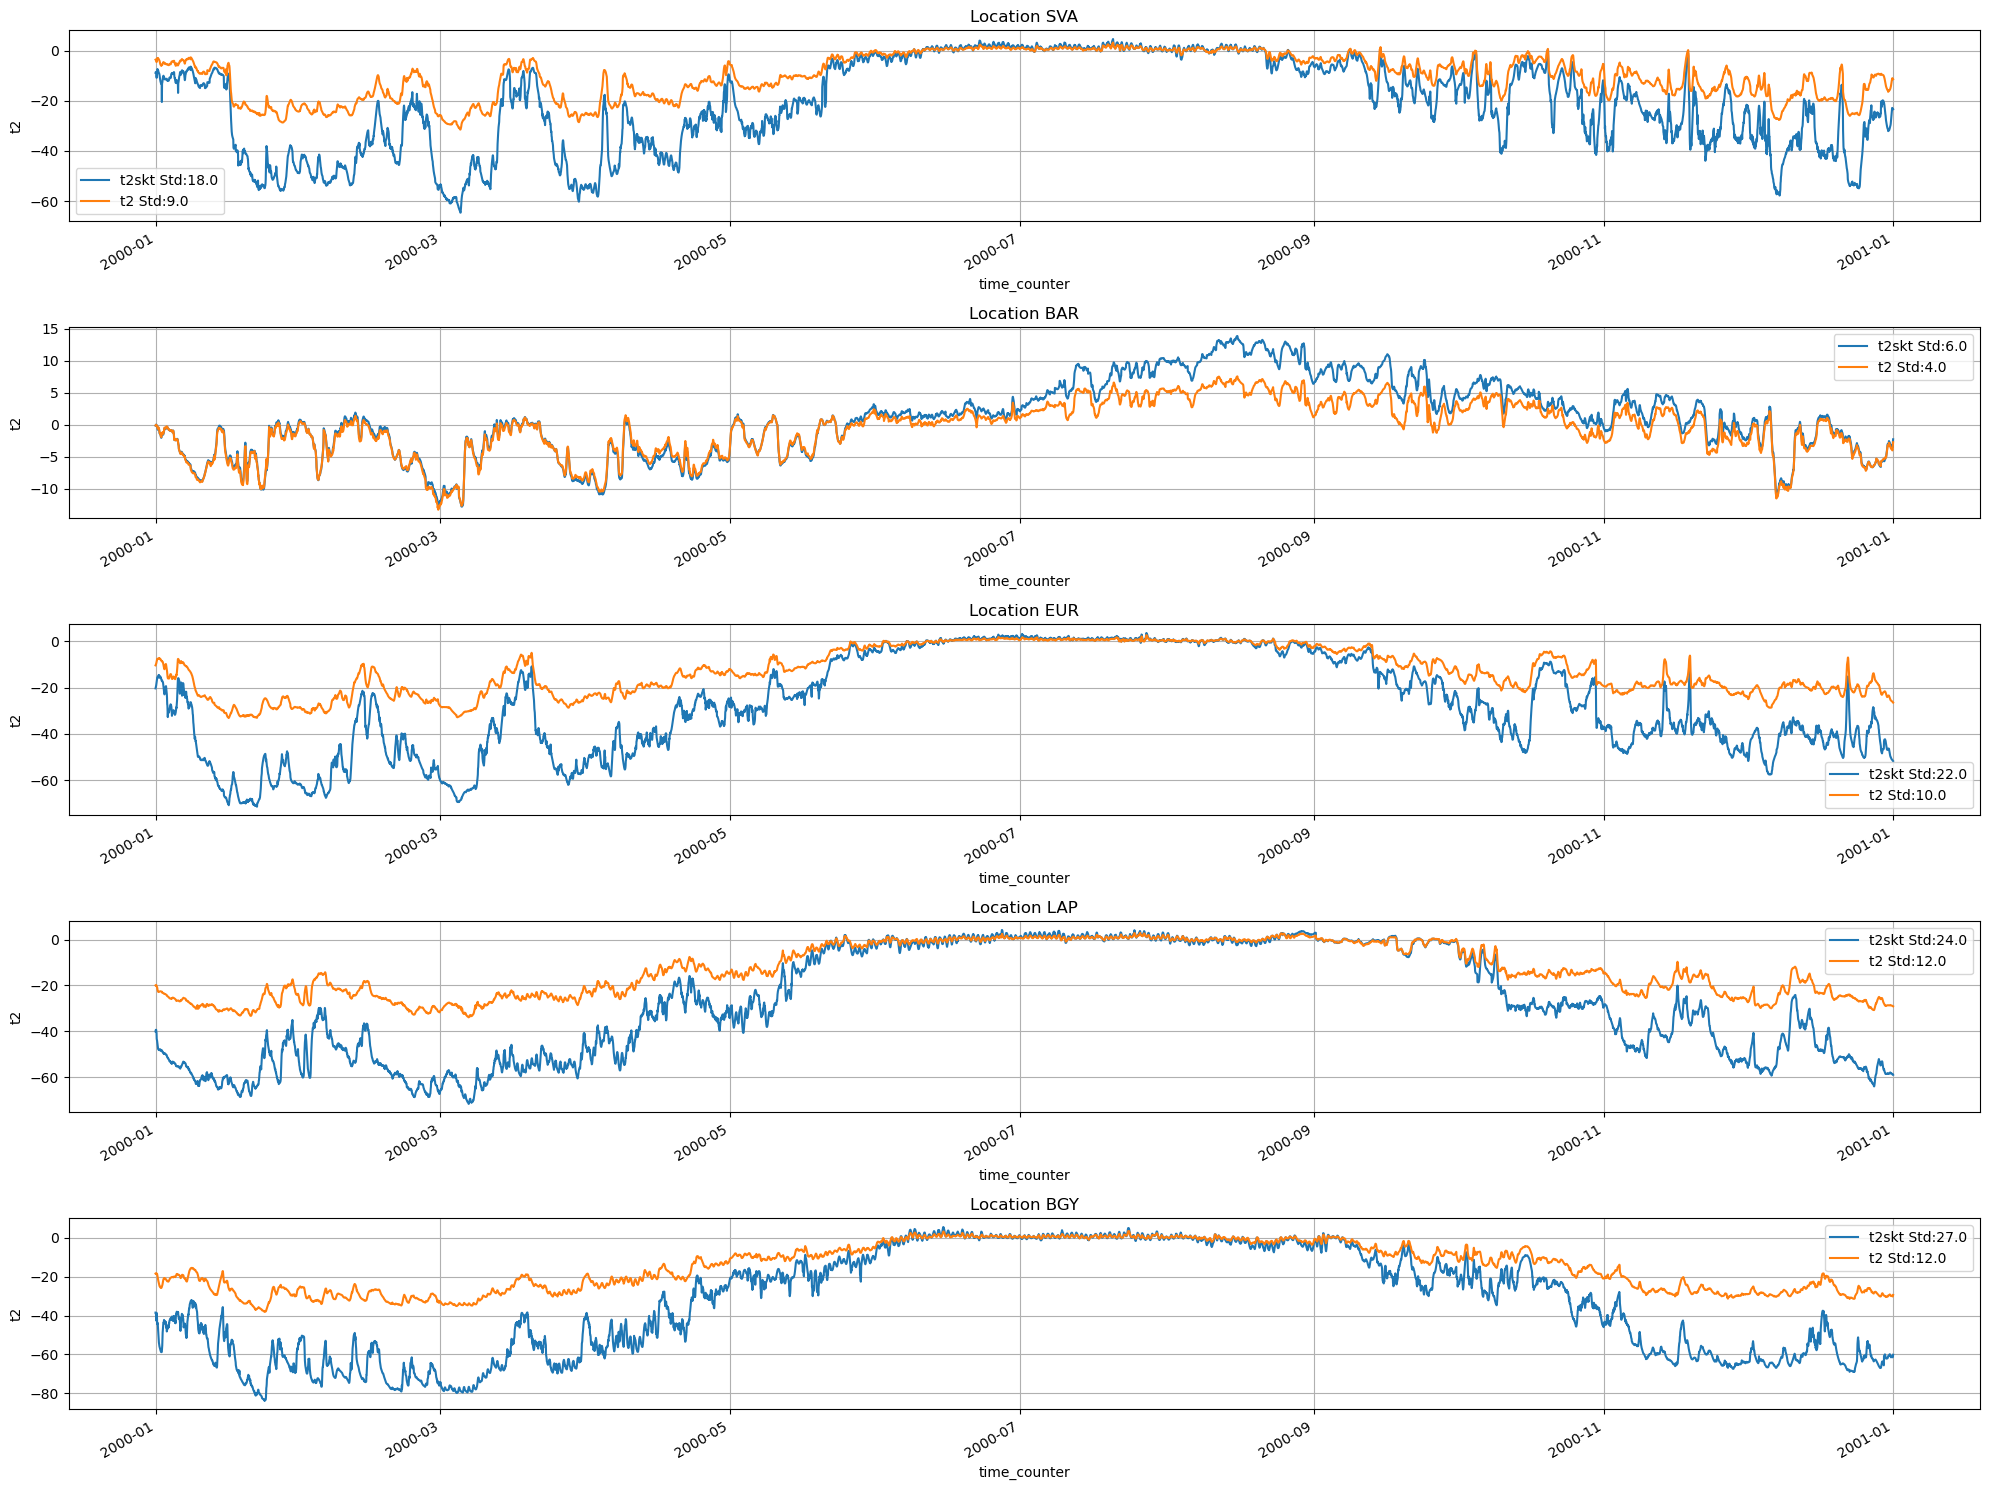

In [34]:
plt.figure(figsize=(20,15))

plt.subplot(511)
std_t2m=ds_t2m['t2'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))

plt.title('Location '+bx_SVAL['name'])
plt.legend()
plt.grid(True)

plt.subplot(512)
std_t2m=ds_t2m['t2'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_BARE['name'])
plt.legend()
plt.grid(True)

plt.subplot(513)
std_t2m=ds_t2m['t2'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_EURA['name'])
plt.legend()
plt.grid(True)

plt.subplot(514)
std_t2m=ds_t2m['t2'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_LAPT['name'])
plt.legend()
plt.grid(True)

plt.subplot(515)
std_t2m=ds_t2m['t2'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_BGYR['name'])
plt.legend()
plt.grid(True)

plt.tight_layout()

if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2m_skt_corrected_TiSe_y'+str(lyear)+'.png',dpi=300)


# Define a function that will apply the correction and save into zarr 

In [9]:
def time_axis(in_array,lyear):    # Rebuild the time axis 
    new_time=pd.date_range(start=str(lyear)+'-01-01',periods=in_array.dims['time_counter'],freq='H',inclusive='left')
    #print('        Year treated '+str(year)+' has '+str(ds_skt.dims['time_counter'])+' hours')
    return new_time

In [9]:
def corr_t2skt(tmask2D,zyear):
    print('Current year : '+str(zyear))
    PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
    
    # Read fields 
    ds_in=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(zyear)+'.nc')
    timeax=time_axis(ds_in,zyear)
    ds_in=ds_in.assign_coords({'time_counter':timeax})
    ds_t2m=ds_in.chunk({'time_counter':1024})
    
    ds_in=xr.open_dataset(PATHIN+'skt/CREG025.L75_drowned_skt_ERA5_y'+str(zyear)+'.nc')
    ds_in=ds_in.assign_coords({'time_counter':timeax})
    ds_skt=ds_in.chunk({'time_counter':1024})
    print('        Input t2 & skt read')
    
    # Apply a mask on the skt field
    ds_skt['skt']=xr.where(tmask2D == 0.,np.nan, ds_skt['skt'])    
    print('    ds_skt',ds_skt.dims)

    # Convert t2m into DegC and apply also a mask
    ds_t2m['t2']=xr.where(tmask2D == 0.,np.nan, ds_t2m['t2']-273.)
    print('    ds_t2m',ds_t2m.dims)
    
    # Apply the correction
    #ds_t2m['t2skt']=ds_t2m['t2']+ds_skt['skt']
    t2skt=ds_t2m['t2']+ds_skt['skt']
    t2skt.name='t2skt'
    print(t2skt.dims)
    print('        Correction applied')
    
    # Rebuild the time axis 
    new_time=pd.date_range(start=str(lyear)+'-01-01',periods=t2skt.shape[2],freq='H',inclusive='left')
    print('        Year treated '+str(year)+' has '+str(t2skt.shape[2])+' hours')
    
    # Build a datasset before saving
    if True:
       
        if False: # This does not ork properly or is too long 
            print('        Build a new dataset') 
            ds_outO=xr.Dataset()
            ds_outO['t2skt']=(('y','x','time_counter'),ds_t2m['t2skt'].values)
            ds_outO.coords['time_counter']=(('time_counter'),new_time)

            ds_out=ds_outO.chunk({'time_counter':512})
            ds_out['longitude']=(('y','x'),ds_t2m['longitude'].values)
            ds_out['latitude']=(('y','x'),ds_t2m['latitude'].values)
            ds_out=ds_out.set_coords(['time_counter','longitude','latitude'])
            #print(ds_out)
        
        # Save into Zarr 
        print('        Save into Zarr') 
        #ds_out.to_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(zyear)+'.zarr')
        t2skt.to_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(zyear)+'.zarr',mode='w')
        #print('        Save into NetCDF') 
        #ds_out.to_netcdf(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(zyear)+'.nc')
        print()
    
    return t2skt
    

In [10]:
%%time 
s_st=2018  ; s_ed=2020
for year in np.arange(s_ed-s_st+1)+s_st:
        lyear=year
        final=corr_t2skt(tmask2D,lyear)

Current year : 2018
        Input t2 & skt read
    ds_skt Frozen({'y': 603, 'x': 528, 'time_counter': 8760})
    ds_t2m Frozen({'y': 603, 'x': 528, 'time_counter': 8760})
('y', 'x', 'time_counter')
        Correction applied
        Year treated 2018 has 8760 hours
        Save into Zarr

Current year : 2019
        Input t2 & skt read
    ds_skt Frozen({'y': 603, 'x': 528, 'time_counter': 8760})
    ds_t2m Frozen({'y': 603, 'x': 528, 'time_counter': 8760})
('y', 'x', 'time_counter')
        Correction applied
        Year treated 2019 has 8760 hours
        Save into Zarr

Current year : 2020
        Input t2 & skt read
    ds_skt Frozen({'y': 603, 'x': 528, 'time_counter': 8784})
    ds_t2m Frozen({'y': 603, 'x': 528, 'time_counter': 8784})
('y', 'x', 'time_counter')
        Correction applied
        Year treated 2020 has 8784 hours
        Save into Zarr

CPU times: user 1.72 s, sys: 2.75 s, total: 4.46 s
Wall time: 2min 34s


# Now compute monthly mean from hourly dataset

In [10]:
%%time 
# Code used for either t2skt or t2 
#zvar='t2skt'
zvar='t2'
PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
s_st=1980  ; s_ed=2020
for year in np.arange(s_ed-s_st+1)+s_st:
    lyear=year
    print(' Current year under process '+str(year))
    if zvar == 't2skt' : 
        # Open the zarr file 
        print('        The variable treated is '+zvar)
        in_array=xr.open_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(lyear)+'.zarr')
        print(in_array.t2skt)
    else: 
        # Open the netcdf file 
        print('        The variable treated is '+zvar)
        in_array=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(lyear)+'.nc')
        #print(in_array.t2)
    print()
    # Set a proper time axis 
    timeax=time_axis(in_array,lyear)
    
    # Build a datasset before saving
    if True:
        print('        Build a new dataset') 
        ds_outO=xr.Dataset()
        if zvar == 't2skt' : 
            ds_outO[zvar]=(('y','x','time_counter'),in_array[zvar].values)
        else: 
            ds_outO[zvar]=(('time_counter','y','x'),in_array[zvar].values)
        ds_outO.coords['time_counter']=(('time_counter'),timeax)
        #print(ds_outO)
               
    # Compute a monthly mean
    if True:
        ds_outOmean=ds_outO.groupby('time_counter.month').mean(dim='time_counter') 
        ds_outOmean.to_netcdf(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_MonMean_ERA5_y'+str(lyear)+'.nc')
    

 Current year under process 1980
        The variable treated is t2

        Build a new dataset
 Current year under process 1981
        The variable treated is t2

        Build a new dataset
 Current year under process 1982
        The variable treated is t2

        Build a new dataset
 Current year under process 1983
        The variable treated is t2

        Build a new dataset
 Current year under process 1984
        The variable treated is t2

        Build a new dataset
 Current year under process 1985
        The variable treated is t2

        Build a new dataset
 Current year under process 1986
        The variable treated is t2

        Build a new dataset
 Current year under process 1987
        The variable treated is t2

        Build a new dataset
 Current year under process 1988
        The variable treated is t2

        Build a new dataset
 Current year under process 1989
        The variable treated is t2

        Build a new dataset
 Current year under process 19

# And finally a seasonal cycle over the full period enumerate

In [11]:
PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
#zvar='t2skt'
zvar='t2'
ds_MonMean = xr.concat([xr.open_dataset(f) for f in fs.glob(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_MonMean_ERA5_y*.nc')],dim='month')
print(ds_MonMean)
ds_MonMean_Seas=ds_MonMean.groupby('month').mean(dim='month')
print(ds_MonMean_Seas)
ds_MonMean_Seas.to_netcdf(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')


<xarray.Dataset>
Dimensions:  (month: 504, y: 603, x: 528)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    t2       (month, y, x) float32 292.2 292.3 292.4 292.4 ... 248.0 248.2 248.3
<xarray.Dataset>
Dimensions:  (month: 12, y: 603, x: 528)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    t2       (month, y, x) float32 293.8 293.8 293.9 293.9 ... 245.9 246.1 246.4


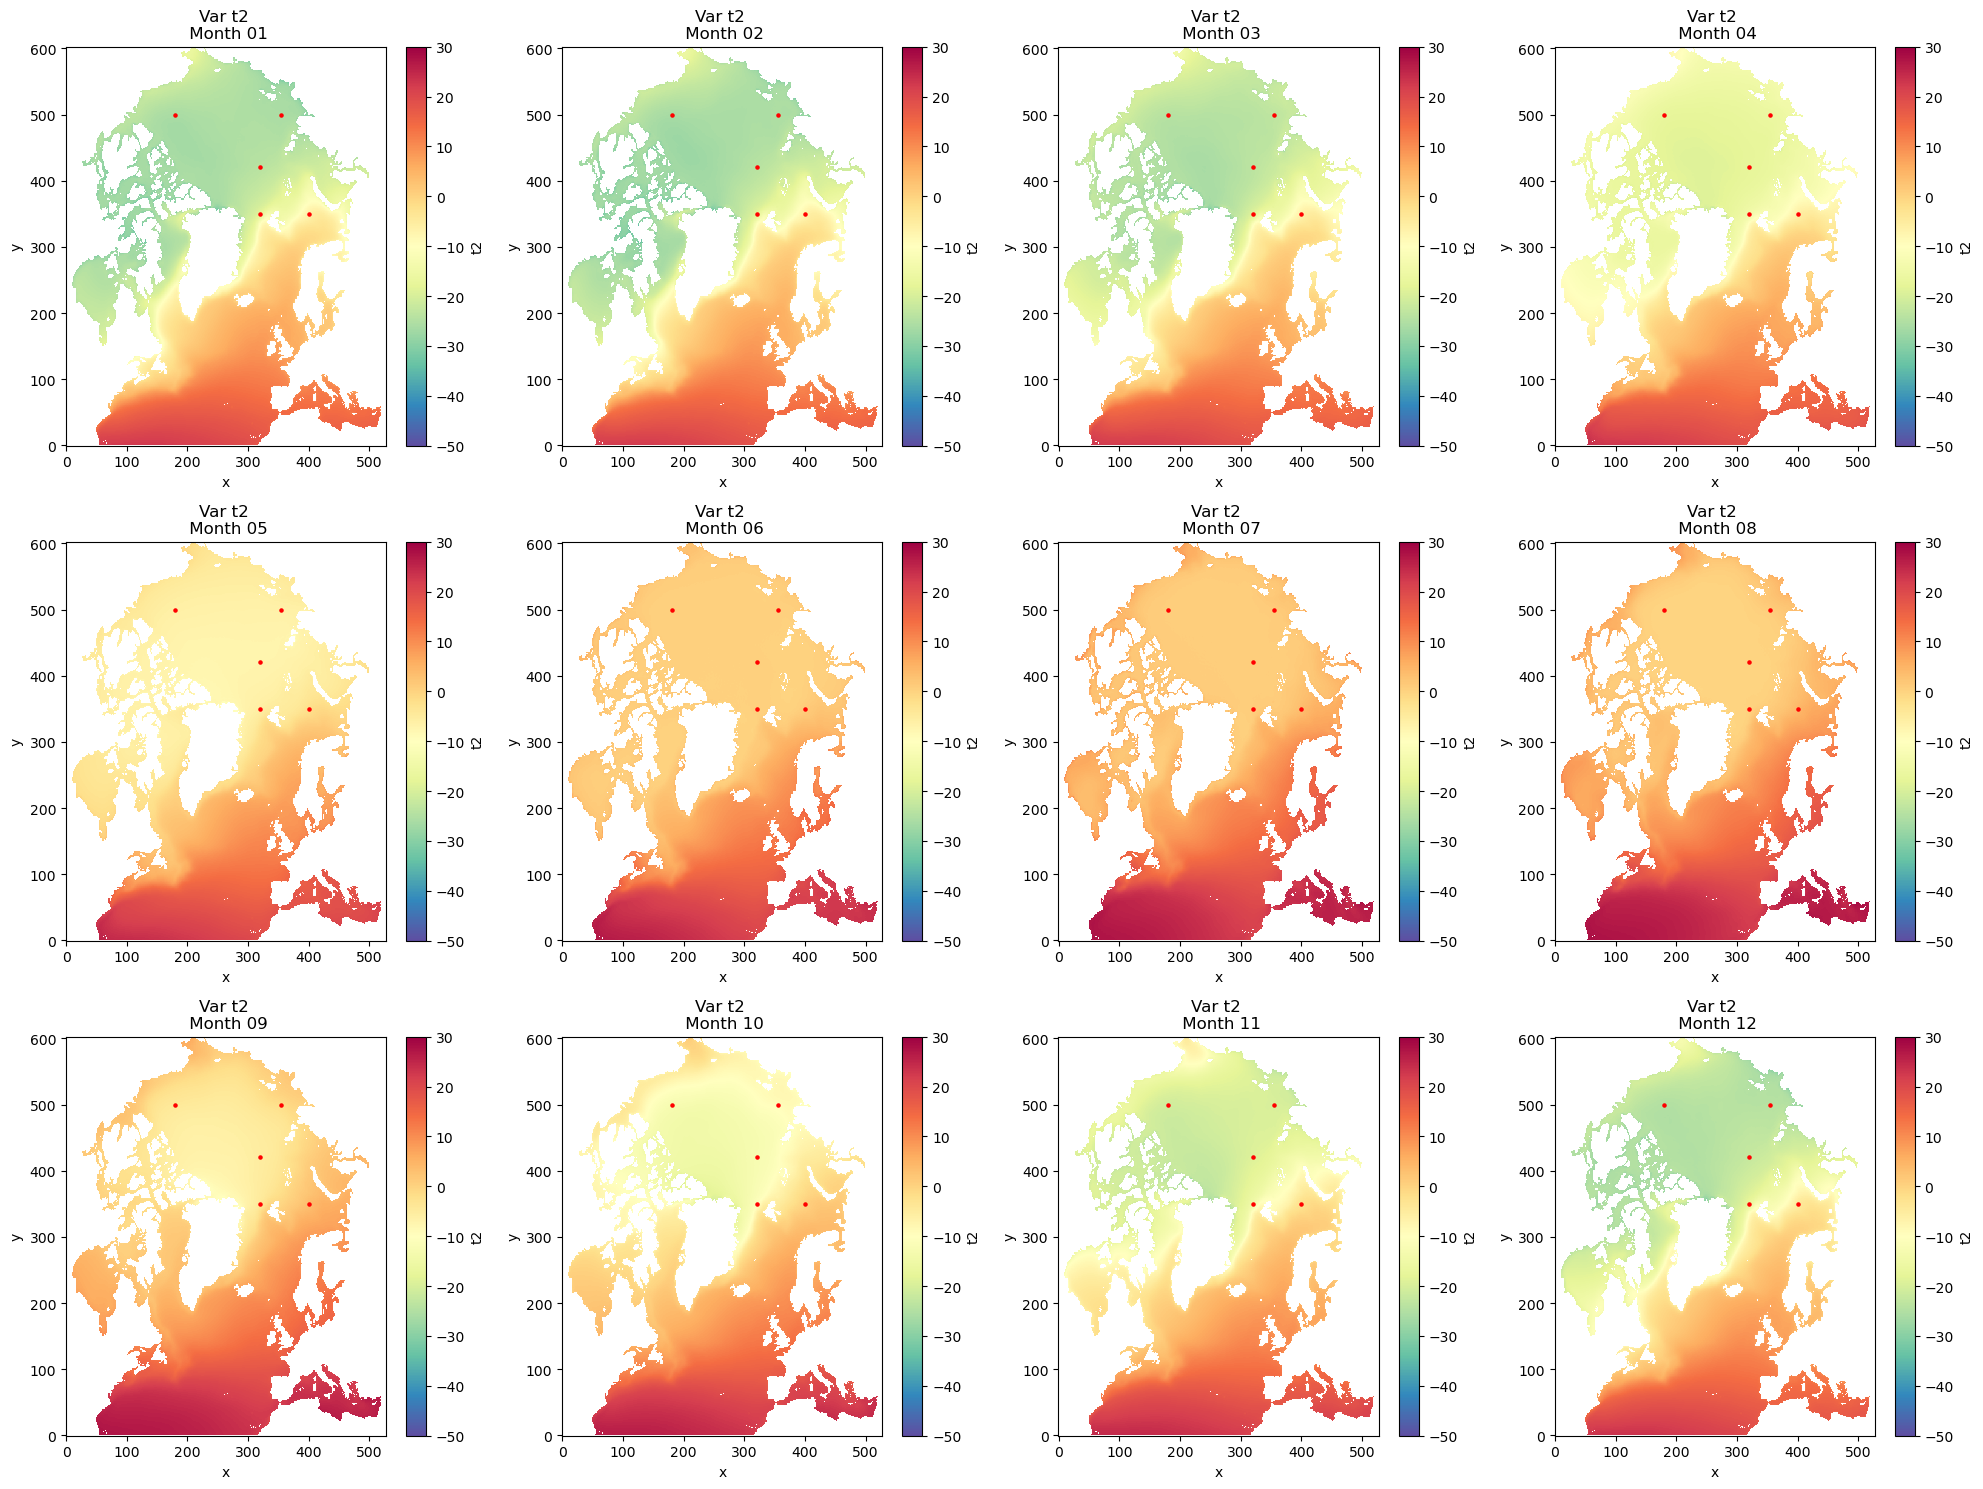

In [36]:
zvar='t2'
#zvar='t2skt'

PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
ds_MonMean_Seas=xr.open_dataset(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')

if zvar == 't2' : 
    ds_MonMean_Seas[zvar]=xr.where(tmask2D == 0.,np.nan, ds_MonMean_Seas[zvar]-273.)

my_min=-50 ; my_max=30.
fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

for i, ax in enumerate(axes.flat):
    i+=1 
    if i < 10: 
        mm='0'+str(i) 
    else : 
        mm=str(i)
    ds_MonMean_Seas[zvar].isel(month=i-1).plot(ax=ax,vmin=my_min,vmax=my_max,cmap='Spectral_r')
    ax.set_title('Var '+zvar+' \n Month '+mm)
    ax.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')

plt.tight_layout()
if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_'+zvar+'_SeasMaps_y1981-2020.png',dpi=300)


# Time-series at specific mooring points of the seasonal cycle

In [33]:
PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/'
zvar='t2skt'
ds_MonMean_Seas_skt=xr.open_dataset(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
zvar='t2'
ds_MonMean_Seas_t2=xr.open_dataset(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
ds_MonMean_Seas_t2['t2']=ds_MonMean_Seas_t2['t2']-273.

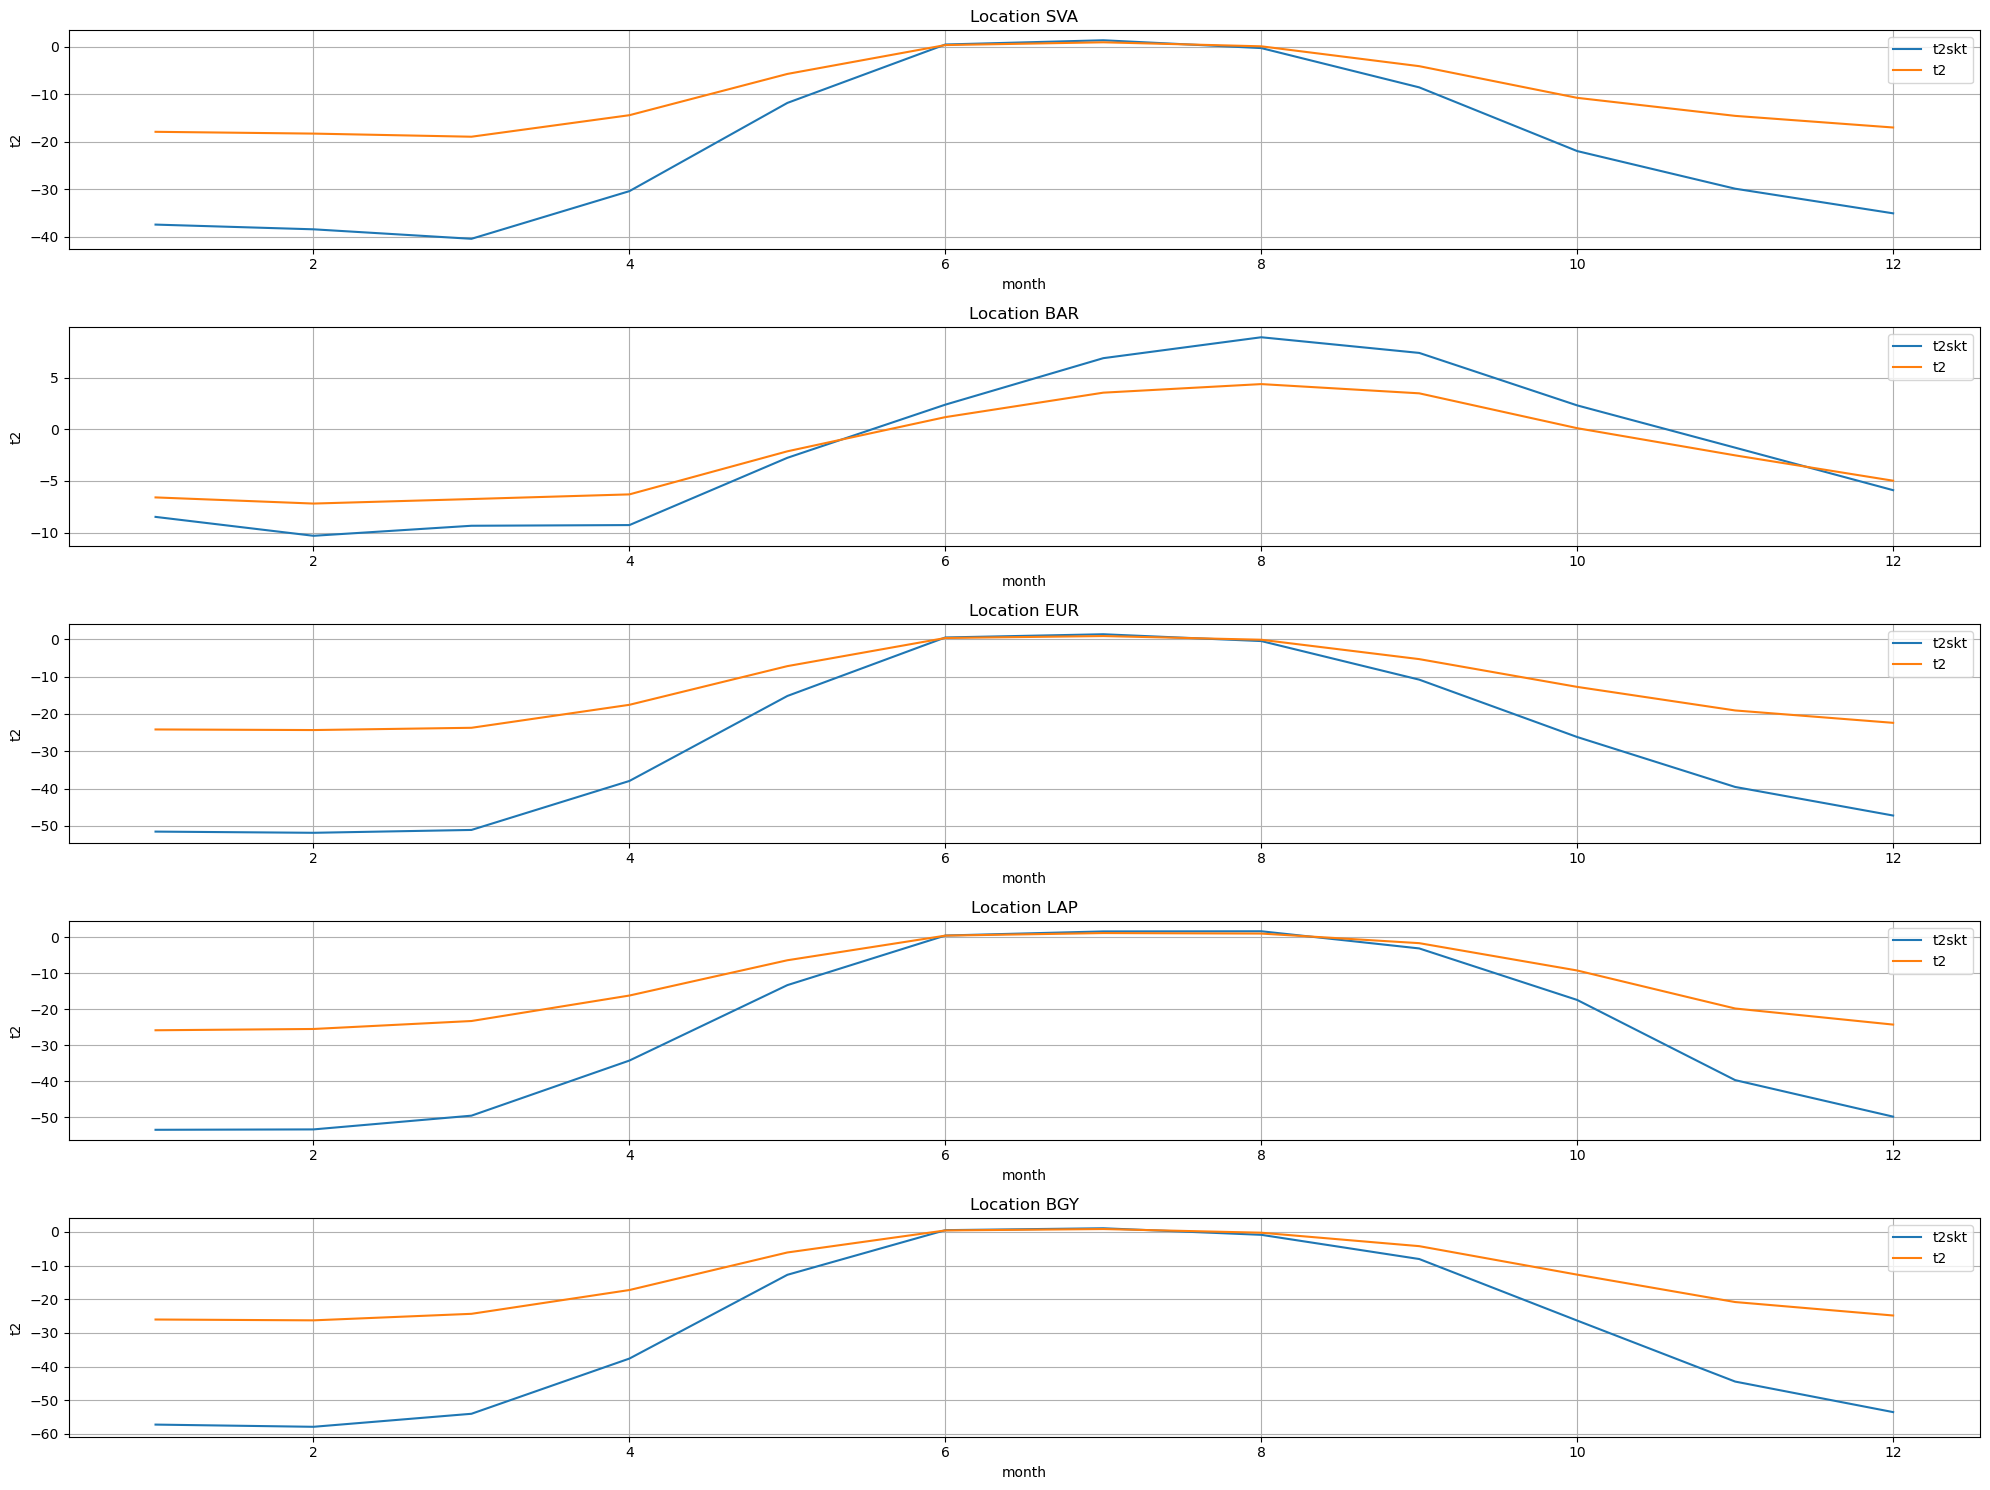

In [34]:
plt.figure(figsize=(20,15))

plt.subplot(511)
ds_MonMean_Seas_skt['t2skt'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2skt')
ds_MonMean_Seas_t2['t2'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2')
plt.title('Location '+bx_SVAL['name'])
plt.legend()
plt.grid(True)

plt.subplot(512)
ds_MonMean_Seas_skt['t2skt'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2skt')
ds_MonMean_Seas_t2['t2'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2')
plt.title('Location '+bx_BARE['name'])
plt.legend()
plt.grid(True)

plt.subplot(513)
ds_MonMean_Seas_skt['t2skt'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2skt')
ds_MonMean_Seas_t2['t2'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2')
plt.title('Location '+bx_EURA['name'])
plt.legend()
plt.grid(True)

plt.subplot(514)
ds_MonMean_Seas_skt['t2skt'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2skt')
ds_MonMean_Seas_t2['t2'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2')
plt.title('Location '+bx_LAPT['name'])
plt.legend()
plt.grid(True)

plt.subplot(515)
ds_MonMean_Seas_skt['t2skt'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2skt')
ds_MonMean_Seas_t2['t2'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2')
plt.title('Location '+bx_BGYR['name'])
plt.legend()
plt.grid(True)

plt.tight_layout()

if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2m_skt_SeasCyc_TiSe_y1981-2020.png',dpi=300)



In [47]:
CASE='DFS52NEM405'
#CASE='ERA01NEM405'
DATA_PATH='/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-'+CASE+'/'

AW_files = [f for f in fs.glob(DATA_PATH+'CREG025.L75-'+CASE+'_AWTmaxClim_y*.nc')]
AW_files                           

['/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.L75-DFS52NEM405_AWTmaxClim_y1979.nc',
 '/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.L75-DFS52NEM405_AWTmaxClim_y1980.nc',
 '/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.L75-DFS52NEM405_AWTmaxClim_y1981.nc',
 '/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.L75-DFS52NEM405_AWTmaxClim_y1982.nc',
 '/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.L75-DFS52NEM405_AWTmaxClim_y1983.nc',
 '/home1/datahome/ctalandi/RUNS/RUN_CREG025.L75/CREG025.L75-ERA01/CTL/CDF/MONARC/MAPS/NCDF-CREG025.L75/CREG025.L75-DFS52NEM405/CREG025.

# Clean projection of the AWTmaxDepth difference by year

/dev/shm/pbs.489344.datarmor0/ipykernel_48708/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.489344.datarmor0/ipykernel_48708/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.489344.datarmor0/ipykernel_48708/768119356.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.489344.datarmor0/ipykernel_48708/768119356.py

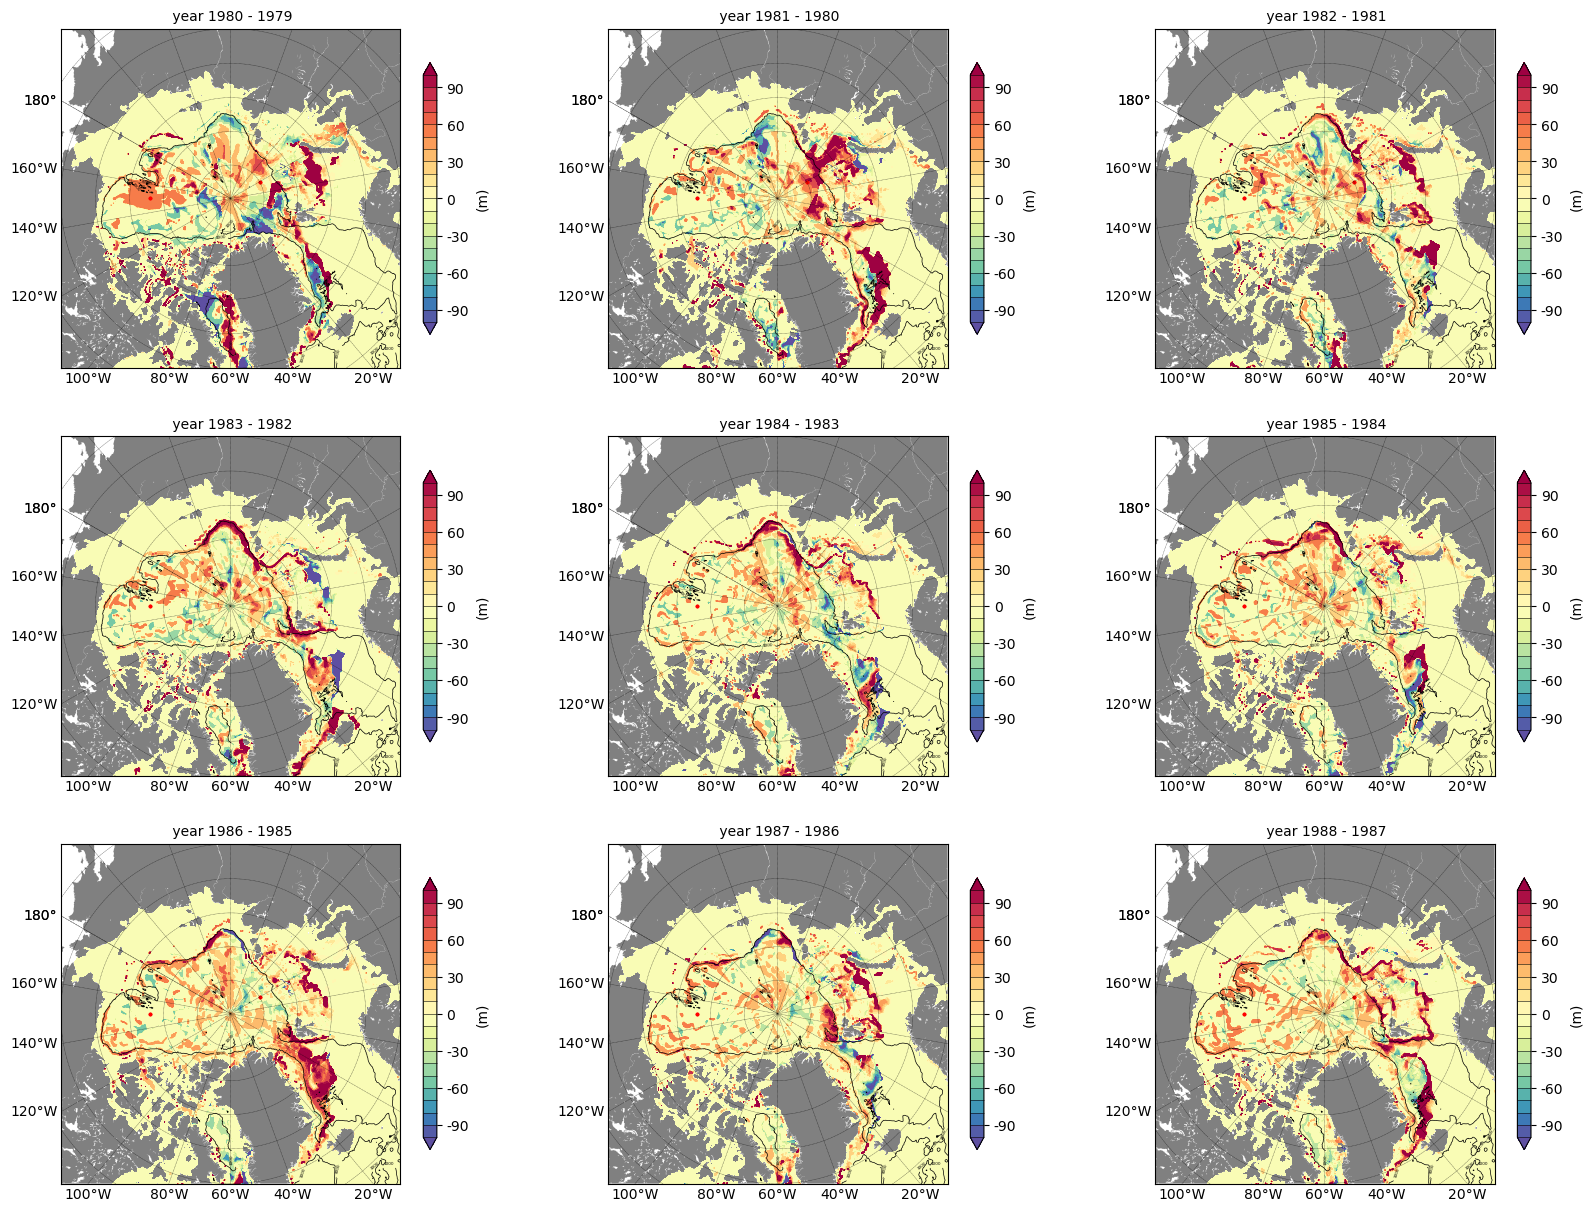

In [55]:
doplot=True
if doplot:
        plt.figure(figsize=(20,15)) 
        #plt.subplot(223)
        ######### AWTmax #########
        my_cblab=r'(m)'
        my_cmap=plt.colormaps['Spectral_r']
        #my_cmap=mpl.cm.get_cmap('Spectral_r')
        #my_cmap=plt.cm.get_cmap('jet')

        m_alpha=1.
        zfile_ext='_AWTmaxDepth'
        vmin=-100. ; vmax=100. ; vint=10.
        contours=np.arange(vmin,vmax+vint,vint)  # optional contours
        limits=[vmin,vmax,vint]                        # limits for eke
        myticks=np.arange(vmin,vmax+vint,vint)   # optional colorbar ticks (None)    
        
        l_lon=ds_AW['lon_mod'].isel(time_counter=0).values
        l_lat=ds_AW['lat_mod'].isel(time_counter=0).values

        y_start=1980 ; 
        faces=9
        for y_start in np.arange(0,5,faces)+y_start:
            for iter in np.arange(faces):
                plt.subplot(331+iter)   
                l_fld=clean_Diff_AWTmaxDepth_mod.sel(time_counter=str(y_start+iter))[:,:,0]
                zoutmap=Arc_Bat(ztype='isol1000')
                ztitle=r' year '+str(y_start+iter)+' - '+str(y_start+iter-1)
                Arc_plot(l_lon,l_lat, l_fld*m_alpha, contours, limits, myticks, \
                         name=ztitle, zmy_cblab=my_cblab, zmy_cmap=my_cmap, zvar='socurl')

            plt.savefig('./FIGURES/CREG025.L75-'+CASE+'_AWTmaxDepthIncrement_y'+str(y_start)+str(y_start+faces-1)+'.png',dpi=300)
    
doplot=False
